In [1]:
import pandas as pd
import numpy as np
import re
import json
import os

from numpy import array

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras import optimizers
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib import rc

In [2]:
building_name = "Comsa2"
floor = "Floor2"
month = "July"

dataset_date_ini = '2020-03-15 00:00:00'
dataset_date_end = '2020-04-28 23:45:00'

visualization_date_ini = '2020-03-26 06:00:00'
visualization_date_fin = '2020-03-27 06:00:00'


ptd = 0.8
method = "step_dTi"
model = "Model3"

if method == "step_Ti":
    combination = 4
elif method == "step_dTi":
    combination = 1
elif method == "block":
    combination = 3

batch_size = 'batch_size = 72'
epochs = 'epochs = 200'

#Febrero: C = 31, R = 1, A = 0
#Julio: C = 10, R = 0.53, Aw = 6.8
if month == "February":
    R = 1
    C = 31
    Aw = 0
    
elif month == "July":
    R = 0.53
    C = 10
    Aw = 6.8
    
else:
    R = 0
    C = 0
    Aw = 0
    

dataset_path = os.path.dirname(os.getcwd())+ '\\Data\\' + floor + '\\' + building_name + '.csv'
results_path = os.path.dirname(os.getcwd()) + 'un\\Results\\' + floor + '\\' + month + '\\'
results_path_method = os.path.dirname(os.getcwd()) + 'un\\Results\\' + floor + '\\' + month + '\\' +  method + '\\'
function_path = os.path.dirname(os.getcwd())+ '\\Functions'

In [3]:
results_path_method

'C:\\Users\\Saioa\\Documents\\2020-21\\Praktikak\\Programak\\COMSA\\both methodsun\\Results\\Floor2\\July\\step_dTi\\'

In [4]:
if not os.path.exists(results_path):
    os.makedirs(results_path)
if not os.path.exists(results_path_method):
    os.makedirs(results_path_method)
    

In [5]:
dataset = pd.read_csv(dataset_path,index_col=0)
dataset

,dTi,Ti,Ta,Ps,Ph,Ti_adj_1,Ti_adj_2
Date,,,,,,,
2019-05-01 02:00:00,NaN,25.2,15.2,0.0,129.0,24.9,25.5
2019-05-01 02:15:00,0.0,25.2,15.2,0.0,129.0,24.8,25.5
2019-05-01 02:30:00,0.0,25.2,15.2,0.0,129.0,24.8,25.5
2019-05-01 02:45:00,0.0,25.2,15.2,0.0,129.0,24.8,25.5
2019-05-01 03:00:00,0.0,25.2,15.3,0.0,129.0,24.7,25.4
...,...,...,...,...,...,...,...
2020-05-01 00:45:00,0.0,23.5,17.8,0.0,129.0,23.1,23.7
2020-05-01 01:00:00,0.0,23.5,17.8,0.0,129.0,23.1,23.7
2020-05-01 01:15:00,0.0,23.5,17.7,0.0,129.0,23.1,23.7


In [6]:
data = dataset.loc[dataset_date_ini:dataset_date_end]
data = data.dropna()
data['Delta'] = pd.DatetimeIndex(data.index).to_series().diff().astype('timedelta64[m]')
data

,dTi,Ti,Ta,Ps,Ph,Ti_adj_1,Ti_adj_2,Delta
Date,,,,,,,,
2020-03-15 00:00:00,0.0,24.5,14.0,0.0,129.0,23.7,24.8,NaN
2020-03-15 00:15:00,0.0,24.5,13.8,0.0,129.0,23.7,24.8,15.0
2020-03-15 00:30:00,0.0,24.5,13.7,0.0,129.0,23.7,24.8,15.0
2020-03-15 00:45:00,0.0,24.5,13.7,0.0,129.0,23.7,24.8,15.0
2020-03-15 01:00:00,0.0,24.5,13.6,0.0,129.0,23.7,24.8,15.0
...,...,...,...,...,...,...,...,...
2020-04-28 22:45:00,-0.1,23.0,18.3,0.0,129.0,22.6,23.4,15.0
2020-04-28 23:00:00,0.0,23.0,18.3,0.0,129.0,22.6,23.3,15.0
2020-04-28 23:15:00,0.0,23.0,18.2,0.0,129.0,22.5,23.3,15.0


In [7]:
def Ph0(dataset,column):
    df = dataset
    cont = 0
    for i in range(0,len(dataset[column])):
        if i == 0:
            if dataset[column][i]<0.15*max(dataset[column]) and dataset[column][i+1]<0.15*max(dataset[column]):
                df[column][i] = 0
                cont +=1
        elif i == len(dataset[column])-1:
            if dataset[column][i]<0.15*max(dataset[column]) and dataset[column][i-1]<0.15*max(dataset[column]):
                df[column][i] = 0
                cont +=1
        else:
            if dataset[column][i]<0.15*max(dataset[column]) and dataset[column][i-1]<0.15*max(dataset[column]) and dataset[column][i+1]<0.15*max(dataset[column]):
                df[column][i] = 0
                cont +=1
    return df,cont

In [8]:
data,cont = Ph0(data,column = 'Ph')

#path_cont_month = os.path.dirname(os.getcwd()) + '\\Results\\' + floor + '\\Ph0_monthly.txt'

#file = open(path_cont_month, 'a+')
#file.write(month+':'+str(cont)+'\n')
#file.close()

In [9]:
data

,dTi,Ti,Ta,Ps,Ph,Ti_adj_1,Ti_adj_2,Delta
Date,,,,,,,,
2020-03-15 00:00:00,0.0,24.5,14.0,0.0,0.0,23.7,24.8,NaN
2020-03-15 00:15:00,0.0,24.5,13.8,0.0,0.0,23.7,24.8,15.0
2020-03-15 00:30:00,0.0,24.5,13.7,0.0,0.0,23.7,24.8,15.0
2020-03-15 00:45:00,0.0,24.5,13.7,0.0,0.0,23.7,24.8,15.0
2020-03-15 01:00:00,0.0,24.5,13.6,0.0,0.0,23.7,24.8,15.0
...,...,...,...,...,...,...,...,...
2020-04-28 22:45:00,-0.1,23.0,18.3,0.0,0.0,22.6,23.4,15.0
2020-04-28 23:00:00,0.0,23.0,18.3,0.0,0.0,22.6,23.3,15.0
2020-04-28 23:15:00,0.0,23.0,18.2,0.0,0.0,22.5,23.3,15.0


In [10]:
data['Ph'].value_counts()

0.0        4296
129.0         4
140.0         3
6679.0        1
5569.0        1
15880.0       1
4940.0        1
5069.0        1
9000.0        1
5269.0        1
6230.0        1
7869.0        1
8439.0        1
5859.0        1
14939.0       1
1500.0        1
6129.0        1
149.0         1
9819.0        1
11069.0       1
Name: Ph, dtype: int64

In [28]:
def preparing_df(data,n_pred,n_values): 

    first = data.index[0]
    df = pd.DataFrame()
    reframed = pd.DataFrame()
    
    i = 0
    dic_ind_date = {}
    
    for index,row in data.iterrows():
        if (row['Delta']!=15.0) and np.isnan(row['Delta']) != True:
            df = data.loc[first:index_1]
            #df.iloc[-5:,:].to_csv(os.getcwd()+'df_salto_prev.csv')
            columns = df.columns[0:n_values+1]
            for j in range(0,len(df.index.array)-4):
                dic_ind_date[i] = df.index.array[j]
                i+=1
            if n_pred == 4:
                values = df.iloc[:,0:n_values+1]
            elif n_pred == 1:
                values = df.iloc[:-3,0:n_values+1]
            values = values.to_numpy()
            values = values.astype('float32')
            reframed = reframed.append(series_to_supervised(values, columns, 64, n_pred+1))
            reframed.iloc[-5:,:].to_csv('ref_prev.csv')
            first = index
            print(index)
        index_1 = index
        
    df = data.loc[first:index_1]
    #df.iloc[0:5,:].to_csv(os.getcwd()+'df_salto.csv')
    for j in range(0,len(df.index.array)-4):
        dic_ind_date[i] = df.index.array[j]
        i+=1
    
    columns = df.columns[0:n_values+1]
    values = df.iloc[0:,0:n_values+1]
    values = values.to_numpy()
    values = values.astype('float32')
    #series_to_supervised(values, columns, 0, n_pred+1).iloc[0:5,:].to_csv('ref_post.csv')
    reframed = reframed.append(series_to_supervised(values, columns, 64, n_pred+1))
    reframed = reframed.reset_index(drop = True)
    values = reframed.iloc[:,:]
    values = values.to_numpy()
    values = values.astype('float32')
    
    return reframed, values, dic_ind_date

In [27]:
len(dic_ind_date)

3986

In [11]:
def moving(df, variables_training, variables_prediction, n_values, method_data):
    '''
    The moving function moves the output columns to the end of the DataFrame.

    INPUT:
    - df: The dataframe we want to modify.
    - n_values: How many variables we have per timestep.
    
    OUTPUT:
    - df: DataFrame with the output variables at the end.
    '''
    if method_data == True:
        df1 = df[variables_training]
        df2 = df[variables_prediction]
        df = pd.concat([df1,df2],axis=1)
    
    
    elif method_data == False:
        columns = df.columns[n_values:len(df.columns):n_values]
        for i in columns:
            first_col = df.pop(i)
            df.insert(len(df.columns),i,first_col)

    return df

In [12]:
def ml_algorithm(building_name, floor, month, method, data,n_pred,n_values, percentage_train_data, results_path, results_path_method,date_1,date_2,R,C,Aw):
    '''
    The ml_algorithm function collects the distribution of all above functions to fit the block and the step methos depending on the 
    value of the n_pred we give. 
    It collects in three csv archives the results: one for collecting the original test data, another for collecting the results of 
    the block method and the last one for collecting the results of the step method.

    INPUT:
    - data: The dataset with all the relevant information for the model.
    - n_pred: Number of output variables.
    - n_values: Number of input variables for each timestep.

    OUTPUT:
    - dic_ind_date: index date dictionary.
    '''
         
    reframed_0,values_0,dic_ind_date_0 = preparing_df(data,4,n_values)
    filter_col_ref = [col for col in reframed_0 if col.startswith('Ti(t+')]
    
    reframed_0 = reframed_0[filter_col_ref]
    print('reframed_0')
    print(reframed_0)
    
    
    reframed,values,dic_ind_date = preparing_df(data,n_pred,n_values)
    #reframed = moving(reframed,variables_training, variables_prediction, n_values, method_data = False )
    variables_to_drop = []
    
    filter_col1 = [col for col in reframed if col.startswith('dT')]
    filter_col2 = [col for col in reframed if col.startswith('Ti_')]
    filter_col3 = [col for col in reframed if col.startswith('Ti(t-')]
    filter_col = [col for col in reframed if col.startswith('Ti(t+')]
    
    reframed = reframed[reframed.columns.drop(filter_col1)]
    reframed = reframed[reframed.columns.drop(filter_col2)]
    reframed = reframed[reframed.columns.drop(filter_col3)]
    
    variables_prediction = filter_col
    variables_training = reframed[reframed.columns.drop(filter_col)].columns
    
    reframed = moving(reframed,variables_training, variables_prediction, n_values, method_data = True )
    '''for column in reframed.columns:
        if column not in variables_training + variables_prediction:
            variables_to_drop.append(column)
    reframed = reframed.drop(columns = variables_to_drop)'''
    print('reframed')
    print(reframed)
    #reframed.loc[0:5].to_csv(results_path + 'r_head.csv')
    
    scale = reframed.iloc[:,:-n_pred]
    scaler,scaled = scaling(scale)
    scaled = np.append(scaled, reframed.iloc[:,-n_pred:].to_numpy(), axis=1)
    print(scaled)

    scaler_Ti,scaled_Ti = scaling(data['Ti'].to_numpy().reshape(-1, 1))
    scaler_Ta,scaled_Ta = scaling(data['Ta'].to_numpy().reshape(-1, 1))
    scaler_Ps,scaled_Ps = scaling(data['Ps'].to_numpy().reshape(-1, 1))

    n_train = int(percentage_train_data*values_0.shape[0])

    print(scaled.shape)
    test_X, test_y, model = training(scaled,n_pred,n_train)  
    
    test_y_aux = reframed_0[filter_col_ref]
    
    df_data = pd.DataFrame(test_y_aux, columns = ['Ti(t+1)','Ti(t+2)','Ti(t+3)','Ti(t+4)'])
    df_data = df_data.reset_index(drop=True)
    
    df_data.to_csv(results_path+'data_konp_'+ building_name + '.csv') 
    
    #block method
    if method == 'block':
        inv_yhat,inv_y = predicting_blocks(test_X,test_y,model,n_pred)
        #inv_yhat,inv_y = predicting_blocks_1(test_X,test_y,model,scaler_Ti,n_pred)
        df = pd.DataFrame(inv_yhat, columns = ['Ti(t+1)','Ti(t+2)','Ti(t+3)','Ti(t+4)'])
        df.to_csv(results_path_method + 'block_pred_' + building_name + '.csv')
        return dic_ind_date, n_train
        

    #step Ti method
    elif method == 'step_Ti':
        all_Ti = predicting_step_Ti(test_X,test_y,model,scaler_Ti,n_pred,4)
        all_Ti = np.array(all_Ti)
        df_Ti = pd.DataFrame(all_Ti, columns = ['Ti(t+1)','Ti(t+2)','Ti(t+3)','Ti(t+4)'])
        df_Ti.to_csv(results_path_method + 'step_Ti_pred_' + building_name + '.csv')
        '''
        if month == 'February' or month == 'July':
            Ti_mean = np.mean(reframed['Ti(t)'][reframed['Ph(t+1)']>0].to_numpy())
            count_array,count_array_RC,df_events,df_RC = Ph0_input_step_Ti(test_X,test_y,model,scaler_Ti,scaler_Ta,scaler_Ps,dic_ind_date,Ti_mean,date_1,date_2,n_train,R,C,Aw,input_position_Ti=0,input_position_Ta=1,input_position_Ps=2,input_position_Ph=3)

            df_count,df_count_RC = storing_flex(reframed,count_array,count_array_RC,dic_ind_date,results_path,n_train)

            df_events.to_csv(results_path_method + 'flex_Ti.csv')
            df_RC.to_csv(results_path + 'flex_RC.csv')

            return dic_ind_date, n_train, Ti_mean, df_count, df_count_RC, df_events, df_RC
        
        else:
            return dic_ind_date, n_train
        '''
        return dic_ind_date, n_train
    #step dTi method
    elif method == 'step_dTi' :
        all_Ti = predicting_step_dTi(test_X,test_y,model,scaler_Ti,n_pred)
        all_Ti = np.array(all_Ti)
        df_Ti = pd.DataFrame(all_Ti, columns = ['Ti(t+1)','Ti(t+2)','Ti(t+3)','Ti(t+4)'])
        df_Ti.to_csv(results_path_method + 'step_dTi_pred_' + building_name + '.csv')
        '''   
        if month == 'February' or month == 'July':
            Ti_mean = np.mean(reframed['Ti(t)'][reframed['Ph(t+1)']>0].to_numpy())
            count_array,count_array_RC,df_events,df_RC = Ph0_input_step_dTi(test_X,test_y,model,scaler_Ti,scaler_Ta,scaler_Ps,dic_ind_date,Ti_mean,date_1,date_2,n_train,R,C,Aw,input_position_Ti=0,input_position_Ta=1,input_position_Ps=2,input_position_Ph=3)
        
            df_count,df_count_RC = storing_flex(reframed,count_array,count_array_RC,dic_ind_date,results_path,n_train)
        
            df_events.to_csv(results_path_method + 'flex_dTi.csv')
            df_RC.to_csv(results_path + 'flex_RC.csv')
        
    
            return dic_ind_date, n_train, Ti_mean, df_count, df_count_RC, df_events, df_RC
        else:
            return dic_ind_date, n_train
        '''   
        return dic_ind_date, n_train

In [13]:
def series_to_supervised(data, columns, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1] #data.shape[1] devuelve el número de columnas
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i)) #df.shift() para desplazar el indice el número de periodos deseado 
        names += [str(columns[j]) + '(t-' + str(i) + ")" for j in range(n_vars)] # le pone el nombre correspondiente a la columna
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [str(columns[j]) + '(t)' for j in range(n_vars)]
        else:
            names += [str(columns[j]) + '(t+' + str(i) + ")" for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [14]:
if method == "step_Ti" or method == "step_dTi":
    n_pred = 1
elif method == "block":
    n_pred = 4


In [15]:
def scaling(df):
    '''
    The scaling function transforms features by scaling each feature to a given range.

    INPUT: 
    - df: Dataframe to be scaled.

    OUTPUT:
    - scaler: The scaling function.
    - scaled: The scaled data in a numpyarray.
    '''
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(df)
    return scaler,scaled

In [16]:
def training(data_array,n_pred,n_train):
    train = data_array[:n_train, :]
    test = data_array[n_train:, :]
    
    # split into input and outputs
    train_X, train_y = train[:, :-n_pred], train[:, -n_pred:] 
    test_X, test_y = test[:, :-n_pred], test[:, -n_pred:]
    
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape(train_X.shape[0], 1, train_X.shape[1])
    test_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1])
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    
    # design network
    model = Sequential()
    model.add(Bidirectional(LSTM(50,return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2]))))
    model.add(Bidirectional(LSTM(50,return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2]))))
    model.add(Dropout(0.2))
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(20))
    model.add(Dense(n_pred))
    model.compile(loss='mae', optimizer='adam')
    
    # fit network
    history = model.fit(train_X, train_y, epochs=200, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    
    return test_X, test_y, model

In [17]:
def predicting_step_Ti(test_X,test_y,model,scaler_Ti,n_pred,n_values):
    all_predictions = [[]]*(len(test_y)-3)

    for index in range(0,len(test_y)-3):
        prediction = []
        for i in range(0,n_values):
            if i == 0:
                dato_a_predecir = test_X[index+i,:,:]
                dato_a_predecir = dato_a_predecir.reshape(1, 1, test_X.shape[2])
                Ti_hat = model.predict(dato_a_predecir)
                prediction = np.append(prediction,Ti_hat)
                

            else:
                dato_a_predecir = test_X[index+i,:,1:]
                Ti_hat_scaled = scaler_Ti.transform(Ti_hat)
                dato_a_predecir = np.concatenate((Ti_hat_scaled,dato_a_predecir), axis=1)
                dato_a_predecir = dato_a_predecir.reshape(1, 1, test_X.shape[2])
                Ti_hat = model.predict(dato_a_predecir)
                prediction = np.append(prediction,Ti_hat)

            all_predictions[index] = prediction
      
    return all_predictions

In [18]:
def predicting_step_dTi(test_X,test_y,model,scaler_Ti,n_pred):
    all_predictions = [[]]*(len(test_y)-3)

    for index in range(0,len(test_y)-3):
        prediction = []
        for i in range(0,4):
            if i == 0:
                dato_a_predecir = test_X[index+i,:,:]
                dato_a_predecir = dato_a_predecir.reshape(1, 1, test_X.shape[2])
                dTi_hat = model.predict(dato_a_predecir)
                Ti_scaled = test_X[index+i,:,-8]
                Ti = scaler_Ti.inverse_transform(Ti_scaled.reshape(1, -1))
                Ti_hat = Ti + dTi_hat
                prediction = np.append(prediction,Ti_hat)
                

            else:
                dato_a_predecir = test_X[index+i,:,1:]
                Ti_hat_scaled = scaler_Ti.transform(Ti_hat)
                dato_a_predecir = np.concatenate((Ti_hat_scaled,dato_a_predecir), axis=1)
                dato_a_predecir = dato_a_predecir.reshape(1, 1, test_X.shape[2])
                dTi_hat = model.predict(dato_a_predecir)
                Ti_scaled = test_X[index+i,:,-8]
                Ti = scaler_Ti.inverse_transform(Ti_scaled.reshape(1, -1))
                #Ti_hat = Ti + dTi_hat
                Ti_hat = Ti_hat + dTi_hat
                prediction = np.append(prediction,Ti_hat)

            all_predictions[index] = prediction
      
    return all_predictions


In [29]:
dic_ind_date, n_train = ml_algorithm(
            building_name = building_name, 
            method = method, 
            floor = floor,
            month = month,
            #vars_ini = vars_ini,
            #variables_training = variables_training,
            #variables_prediction = variables_prediction,
            data =  data, 
            n_pred = n_pred, 
            n_values = 4,
            percentage_train_data = ptd,
            results_path = results_path,
            results_path_method = results_path_method,
            date_1 = visualization_date_ini,
            date_2 = visualization_date_fin,
            R = R,
            C = C,
            Aw = Aw)

TypeError: can only concatenate str (not "int") to str

In [20]:
results_path

'C:\\Users\\Saioa\\Documents\\2020-21\\Praktikak\\Programak\\COMSA\\both methodsun\\Results\\Floor2\\July\\'

In [21]:
def visualization(method, building_name, floor, month, date_1, date_2, dic_ind_date, n_train, results_path, results_path_method):
    
    key1 = get_key(date_1,dic_ind_date)
    key2 = get_key(date_2,dic_ind_date)
    
    print(key1,key2)
    
    data_vis = pd.read_csv(results_path + "data_konp_" + building_name + '.csv',index_col = 0)
    Ti_data = data_vis.iloc[n_train:,:]
    Ti_data = Ti_data.to_numpy()
    Ti_data = Ti_data.astype('float32')
    
    method_vis = pd.read_csv(results_path_method + method + '_pred_' + building_name + '.csv',index_col = 0)
    Ti_method = method_vis.iloc[:,:]
    Ti_method = Ti_method.to_numpy()
    Ti_method = Ti_method.astype('float32')
    
    n_pred = 4
    err_method = []

    
    for i in range(0,n_pred):
        rmse_1 = np.sqrt(mean_squared_error(Ti_data[key1-n_train:key2-n_train,i], Ti_method[key1-n_train:key2-n_train,i]))
        err_method = np.append(err_method,rmse_1)
        
    for i in range(0,4):
        date = []
        x = [k for k in range (0,key2-key1+4,4)]
        for j in range(key1+i,key2+i+4,4):
            date = np.append(date,np.array(dic_ind_date[j]))
        plt.xticks(x, date, rotation=90)
        
        plt.plot(Ti_data[key1-n_train:key2-n_train,i],label='data')
        if method == 'block':
            plt.plot(Ti_method[key1-n_train:key2-n_train,i],label='block',color="orange")
            plt.title(label = month +' Ti(t+'+str(i+1)+')', fontsize=14, fontweight="bold", pad = 20)
          
        elif method == 'step_Ti':
            plt.plot(Ti_method[key1-n_train:key2-n_train,i],label= 'step Ti',color="green")
            plt.title(month + ' Ti(t+'+str(i+1)+')', fontsize=14, fontweight="bold", pad = 20)
        
        elif method == 'step_dTi':
            plt.plot(Ti_method[key1-n_train:key2-n_train,i],label='step dTi',color="deeppink")
            plt.title(month + ' Ti(t+'+str(i+1)+')', fontsize=14, fontweight="bold", pad = 20)
        
        plt.subplots_adjust(left=None, bottom=None, right=1.4, top=1.2, wspace=None, hspace=None)
        plt.legend()
        plt.grid()
        name = method + building_name +'Ti(t+'+str(i+1)+')'+'.png'
        plt.tight_layout()
        plt.savefig(results_path_method + name, bbox_inches='tight', dpi = 400)
        plt.show()    
        
    return err_method

In [22]:
def get_key(val,dic):
    '''
    The get_key function returns a key of a given value in a dictionary.

    INPUT:
    - val: Value to find in the dictionary.
    - dic: The dictionary in which the information is collected.

    OUTPUT:
    - key: key associated to the value in the dictionary.
    '''
    for key, value in dic.items():
         if val == value:
            return key

3726 3822


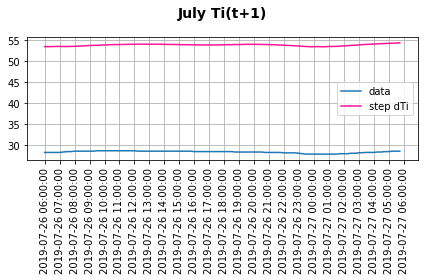

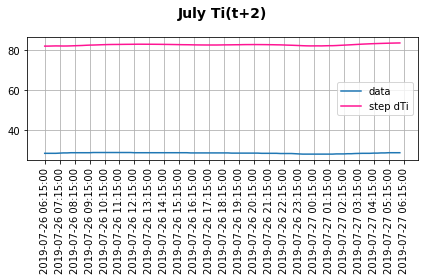

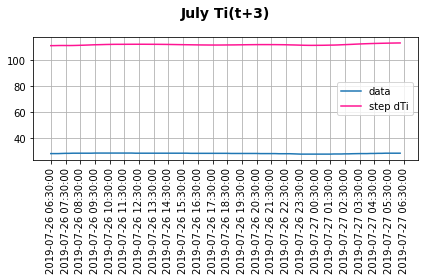

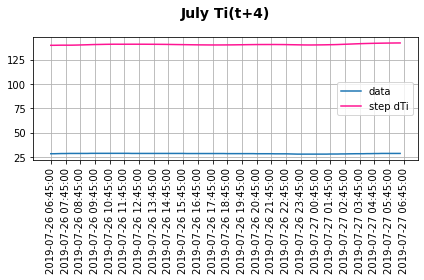

In [25]:
err_method = visualization(method, building_name, floor, month, visualization_date_ini, 
                           visualization_date_fin, dic_ind_date, n_train, results_path, results_path_method)

In [24]:
err_method

array([ 25.47009277,  54.24488831,  83.16331482, 112.19776917])